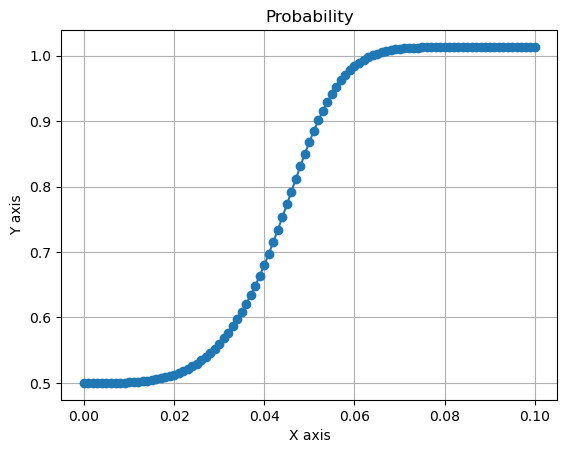

0

In [11]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


h = 1.0
h_k = 1.0

T = 0.1 
dt = 0.001 

n = T/dt
int_n = int(n)

s0 = np.matrix([[1,0],[0,1]]) #matrix_2x2
sx = np.matrix([[0,1],[1,0]]) #matrix_2x2
sy = np.matrix([[0,-1j],[1j,0]]) #matrix_2x2
sz = np.matrix([[1,0],[0,-1]]) #matrix_2x2

ground_state_x = np.matrix([[1/np.sqrt(2)],[1/np.sqrt(2)]]) #vector_2x1
ground_state_z = np.matrix([[1],[0]]) #vector_2x1
conjugate_matrix_x = np.transpose(ground_state_x) #vector_1x2

final_prob = np.zeros((int_n+1,2)) #matrix_2xn


def Hamiltonian(lambda1):
    Hamiltonian_scalar1 = 1.0-lambda1
    Hamiltonian_scalar2 = lambda1*h
    H = np.multiply(Hamiltonian_scalar1,sz) + np.multiply(Hamiltonian_scalar2,sx)
    
    return H #matrix_2x2
    
    
def Lambda_1(t):
    x = np.sin(np.pi*t/2.0/T)**2
    y = x*np.pi/2.0
    z = np.sin(y)**2

    return z #scalar


def Gauge_potential(lambda1):
    Gauge_potential_scalar_L = h_k * (lambda1 - 1.0) - h_k * lambda1
    Gauge_potential_scalar_M = 4.0 * (1.0 - lambda1)**2 + 4.0 * (h * lambda1)**2
    Gauge_potential_scalar_T = -2.0 * Gauge_potential_scalar_L  / Gauge_potential_scalar_M

    A = np.multiply(Gauge_potential_scalar_T,sy)
    
    return A #matrix_2x2


def Derivative_lambda(t_value,T_value):  
    t, P = sp.symbols('t P', real=True)
    expr = sp.sin(sp.pi / 2.0 * sp.sin(sp.pi * t / (2.0 * P))**2)**2

    derivative_expr = sp.diff(expr, t)
    derivative_value = derivative_expr.subs({t: t_value, P: T_value})
    numerical_derivative = float(derivative_value)
    
    return numerical_derivative #scalar


def H_CD(t):
    H_CD_scalar1 = Derivative_lambda(t,T)
    H_CD_scalar2 = Lambda_1(t)
    H_CD_matrix1 = Hamiltonian(H_CD_scalar2)
    H_CD_matrix2 = Gauge_potential(H_CD_scalar2)
    
    H = H_CD_matrix1 + np.multiply(H_CD_scalar1,H_CD_matrix2)
    
    return H #matrix_2x2


def Phi(state,t):   
    Phi_matrix1 = s0 - H_CD(t) * dt * 1.0j
    new_state = np.dot(Phi_matrix1,state)
         
    return new_state #vector_2x1


def Evolution():
    current_state = ground_state_z
    
    for i in range(0,int_n+1):
        float_i = float(i)
        current_state = Phi(current_state, float_i * dt)
        
        amplitude = np.dot(conjugate_matrix_x,current_state)
        probability = abs(amplitude)**2
        final_prob[i,0] = probability
        final_prob[i,1] = i * dt

    return final_prob
        

def Draw(final_prob):
    x = final_prob[:, 1]
    y = final_prob[:, 0]
    plt.plot(x, y, marker='o', linestyle='-')

    plt.title('Probability')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')

    plt.grid(True)
    plt.show()
    
    return 0


Outcome = Evolution()
Draw(Outcome)

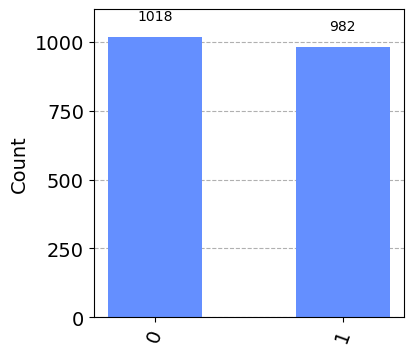

In [2]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp


h_k = 1.0 
T = 1.0 
dt = 0.01
n = T/dt 
int_n = int(n)


def Lambda_1(t):
    x = np.sin(np.pi*t/2.0/T)**2
    y = x*np.pi/2.0
    z = np.sin(y)**2

    return z #scalar


def Derivative_lambda(t_value,T_value):  
    t, P = sp.symbols('t P', real=True)
    expr = sp.sin(sp.pi / 2.0 * sp.sin(sp.pi * t / (2.0 * P))**2)**2

    derivative_expr = sp.diff(expr, t)
    derivative_value = derivative_expr.subs({t: t_value, P: T_value})
    numerical_derivative = float(derivative_value)
    
    return numerical_derivative #scalar


def Gauge_potential_2(lambda1):
    Gauge_potential_scalar_L = h_k
    Gauge_potential_scalar_M = (4.0 * (lambda1 - 1.0) * lambda1) + 2.0
    Gauge_potential_scalar_T = 1.0 * Gauge_potential_scalar_L  / Gauge_potential_scalar_M

    return Gauge_potential_scalar_T #scalar


def Quantum(i):
    cirq = QuantumCircuit(1)
    
    scalar_1 = Lambda_1(i)
    scalar_2 = Derivative_lambda(i,T)
        
    theta_X = scalar_1
    theta_Y = Gauge_potential_2(scalar_1) * scalar_2
    theta_Z = (1.0 - scalar_1)
        
    cirq.rx(2.0 * theta_X * i, 0)
    cirq.ry(2.0 * theta_Y * i, 0)
    cirq.rz(2.0 * theta_Z * i, 0)
    
    U = cirq.to_gate()
    U.name ='CD.{}'.format(i)
        
    return U

def main():
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    Evolution = QuantumCircuit(q,c)
    Evolution.h(q[0])

    for i in range(0,int_n+1):
        float_i = float(i)
        time = float_i * dt

        Ev_stage = Quantum(time)
        Evolution.append(Ev_stage,[q[0]]) 
     
    Evolution.h(q[0])
    Evolution.measure(q,c)

    #Evolution.draw('mpl')
    
    return Evolution


Final_state = main()

sim = Aer.get_backend('aer_simulator')
shots = 2000
count_Evolution = execute(Final_state, sim, shots=shots).result().get_counts()
plot_histogram(count_Evolution, figsize=(4,4))